In [1]:
'''
Example notebook for the demonstration of the JAX-implemented NRSur7dq4 waveform and a comparison to the gwsurrogate implementation

'''
from jaxNRSur.SurrogateModel import NRSur7dq4Model
import jax.numpy as jnp
import numpy as np
import jax
from scipy.interpolate import interp1d
import equinox as eqx
from jaxNRSur.PolyPredictor import evaluate_ensemble_dynamics_at_index

import matplotlib.pyplot as plt
from jaxtyping import Array, Float, Int


# Specifying the parameters of choice
q = 2
incl = 1.4376
phiref = 2.65

chi1 = jnp.array([0.0, 0, 0.0])
chi2 = jnp.array([0.0, 0, 0.0])

params = jnp.concatenate([jnp.array([q]), chi1, chi2])


# Evaluating the waveform, note that at this time, the JAX waveform model also outputs the dynamics
# TODO 1) the first entry is meant to be the time array - however, it is not used in the code. GWSurrogate has the option for this, though also doesn't utilize it
# TODO 2) the JAX waveform doesn't utilize a f_low or a f_ref yet for the waveform, nor does it have the different selections of units (e.g. dimensionsless or mks etc) or
# output types (e.g. with or without combining the modes, whether to return the dynamics etc).
# TODO 3) A number of sections of the code could be optimized, specifically when the modes are being computed and combined. Currently these calculations make use a for loop that can be vmapped. 
model = NRSur7dq4Model()
waveform_jax, dyn_jax = model.get_waveform(jnp.linspace(0, 1, 10), params, theta=incl, phi=phiref)


# Importing GWSurrogate and evaluating it
# Note that it uses the same parameters (though takes more arguments)
import gwsurrogate

gwsurrogate.catalog.pull('NRSur7dq4')
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

# Note that I evaluate the waveform with gwsurrogate
t, h, dyn = sur(q, chi1, chi2, dt=1, f_low=0, inclination=incl, phi_ref=phiref, units='dimensionless', precessing_opts={'return_dynamics': True})


/workspaces/JaxNRSur/src/jaxNRSur/PolyPredictor.py:29: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  def predict(


Try loading file from cache
Cache found and loading data


TypeError: dot_general requires contracting dimensions to have the same shape, got (100,) and (9,).

/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


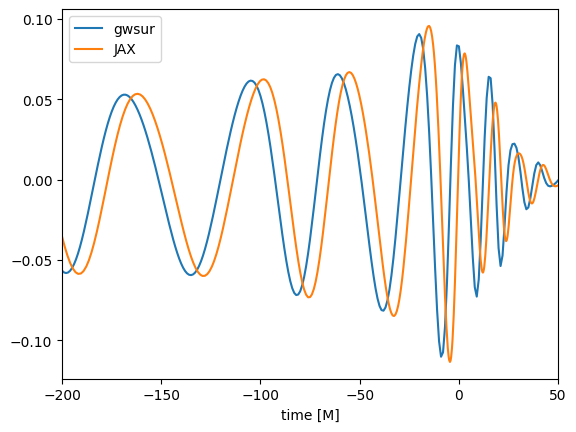

In [ ]:
# Plotting the full waveform at a specific sky location
# This is basically the final time-domain result required
# TODO 4) you'll note here that the phasing is different. This is due to the currently poor integrator for the orbital dynamics 

plt.plot(t, h, label='gwsur')
plt.plot(model.data.t_coorb, waveform_jax, label='JAX')

plt.xlabel('time [M]')
plt.legend(loc='upper left')

plt.xlim(-200,50)

plt.show()

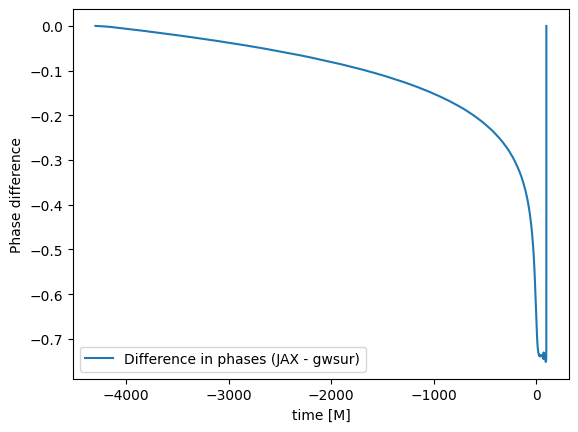

In [ ]:
# The above issue with the error in the orbital dynamics is highlighted here by comparing the phase evolution calculated
# Note that in the test/test_wf_dynamics.ipynb notebook, I've demonstrated that everything downstream of the orbital dynamics integrator is working appropriately. 
plt.plot(model.data.t_coorb, dyn_jax[:,4]-interp1d(t, dyn['orbphase'][:,], bounds_error=False, fill_value=0)(model.data.t_coorb), label='Difference in phases (JAX - gwsur)')

plt.xlabel('time [M]')
plt.ylabel('Phase difference')
plt.legend(loc='best')

plt.show()